In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re 

#Fonction pour trouver les codes correspondants à un pays entre les codes de pays et le nom des pays :"
def equiv (x):
    return(df1[df1['Country Name'] == x]['Country Code'][0])

#fonction pour trouver toutes les lignes qui correspondent à un pays où à une variable en particulier

def recherche_ligne (x,y,df) :
    if x == 'Pays' :
        expression = re.compile(y+".*?;")
        return(expression.findall(';'.join(df.index))) 
    else :
        expression = re.compile(".{,4}"+y+";")
        return(expression.findall(';'.join(df.index)))

#
#Si l'utilisateur cherche des lignes en fonction de pays il faut le mettre dans x
#
#sinon on recherche d'autres caractéristiques (/!\ il faut entre le nom avec des caractères regex pour les ( et %)
#
#/!\ Attention /!\ : avec cette fonction on renvoit lsites de chaines de caractères qui correspondent aux noms des
#colonnes + le séparateur qu'on a utilisé ";" il faut donc le supprimer en ne prenant pas le dernier caractères des
#chaines [:,-1]



        

# On va télécharger les bases de données et repérer les variables pertinentes dans chacune des bases

### On commmence par créer les dataframe

Il faut légèrement modifier le fichier csv dézippé pour enlever les deux premières lignes, qui ne comprennent que des infos générales sur le format du fichier mais qui entrainaient un problème d'ouverture via la commande pd.read_csv car elles comportaient des virgules.

On peut ensuite ouvrir sereinement toutes les base modifiées ainsi.

In [7]:
agri_forest = pd.read_csv("chiffre_agri_foret_peche.csv")
augment_pib = pd.read_csv("chiffre_augment_pib.csv")
energie_utilisee = pd.read_csv("chiffre_energie_utilise.csv")
emission_GES = pd.read_csv("chiffre_GES_total.csv")
nucle_total = pd.read_csv('chiffre_nucle_total_nuke_total_fossile.csv')
part_indus_construc = pd.read_csv('chiffre_part_indus_construc.csv')
pib = pd.read_csv("chiffre_pib.csv")
nom_pays = pib['Country Name']

In [8]:
df_list  = [agri_forest, augment_pib, energie_utilisee, emission_GES, nucle_total, part_indus_construc, pib]

### On regarde chaque dataframe pour identifier les variables pertinentes

In [9]:
agri_forest.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
augment_pib.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.369863,4.198232,0.3,5.700001,2.1,1.999999,NaN,NaN,NaN,NaN


In [11]:
energie_utilisee.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Energy use (kg of oil equivalent per capita),EG.USE.PCAP.KG.OE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
emission_GES.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Émissions totales de GES (kt d’équivalent CO2),EN.ATM.GHGT.KT.CE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
nucle_total.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Alternative and nuclear energy (% of total ene...,EG.USE.COMM.CL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
part_indus_construc.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Industry (including construction), value added...",NV.IND.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
pib.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN


On observe que tous les df sont construits de la même manière. On a le nom du pays, son abréviation, le nom de l'indicateur utilisé, son code, puis sa valeur pour chaque année. On a aussi toujours une colonne vide, qui ne nous gène pas vraiment.

### On nettoie les bases en enlevant les informations qui ne nous intéresse pas

Il faudra enlever la colomne "unnamed", les colomnes qui correpondent aux années qui ne nous intéresssent pas, et éventuellement les lignes (=pays ou région) que l'on ne garde pas.

Par exemple, conserve-t-on les pays comme Aruba dont on ne connait que le PIB? Je pense que la question elle est vite répondue.

Pareil, est-ce que ça a vraiement un intérêt de garder les zones géographiques du type Asie du Sud-Est, etc?  ce ne sont que des aggrégats de pays, donc pas forcément.

### On fusionne les dataframe pour aggréger tous ces indicateurs

On peut envisager plusieurs manières de fusionner ces df. Soit on a en index Pays_Année et les colomnes correspindent chacune à un indice, soit on a Pays_Indicateur et les colonnes correspondent chacune a une année. Ce sont les formats wide et long (cf tp2).

Pour des raisons de lisibilité, il est évident que l'on va conserver le nom de l'indicateur, et non pas son nom de code. En revanche, il faudra voir à l'usage si on préfère utiler le nom complet des pays ou seulement leur nom de code

In [16]:
#On a ici la syntaxe qui permet de créer une nouvelle colomne en lui domnant le nom que l'on souhaite
pib['Pays_indic'] = pib['Country Code'].str[:3] + '_pib'

In [17]:
#On fait ici la modif sur tous les df à l'aide d'une boucle for, 
#mais ça peut donner des noms de variable un peu long à manipuler
for df in df_list :
    df['Pays_indic'] = df['Country Code'].str[:3] + '_' + df['Indicator Name'].str[:99]
#part_indus_construc['Pays_indic']

On concatène les df, on les trie et on met en index la variable créée à cet effet ci-dessus.

In [18]:
df = pd.concat(df_list)
df = df.sort_values('Pays_indic').set_index('Pays_indic')
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
Pays_indic,,,,,,,,,,,,,,,,,,,,,
"ABW_Agriculture, forestry, and fishing, value added (% of GDP)",Aruba,ABW,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_Alternative and nuclear energy (% of total energy use),Aruba,ABW,Alternative and nuclear energy (% of total ene...,EG.USE.COMM.CL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_Energy use (kg of oil equivalent per capita),Aruba,ABW,Energy use (kg of oil equivalent per capita),EG.USE.PCAP.KG.OE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_GDP (current US$),Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN
ABW_GDP growth (annual %),Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.369863e+00,4.198232e+00,3.000000e-01,5.700001e+00,2.100000e+00,1.999999e+00,NaN,NaN,NaN,NaN


### Suppression des colonnes et lignes inutiles

On a ici la liste des colonnes que l'on supprimme pour se restreindre aux données qui nous intéressent, sutrement dit à partir de 1980 (je ne sais plsu si on avait dit 1980 ou 1985).

In [19]:
useless_data_list = ['Unnamed: 65', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', 
                   '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '2020']
df = df.drop(useless_data_list, axis = 1)
#df.sample(15)

On va chercher à enlever les lignes qui ne contiennent que peu d'infos (au moins 10 valeurs manquantes)

In [20]:
df1 = df
nan_dict = {}
for i in range(len(df1.index)) :
    nb_nan = df1.iloc[i].isnull().sum()
    if nb_nan >10 :
        nan_dict[list(df.index)[i]] = nb_nan
nan_dict

{'ABW_Agriculture, forestry, and fishing, value added (% of GDP)': 25,
 'ABW_Alternative and nuclear energy (% of total energy use)': 40,
 'ABW_Energy use (kg of oil equivalent per capita)': 40,
 'ABW_Industry (including construction), value added (% of GDP)': 25,
 'ABW_Émissions totales de GES (kt d’équivalent CO2)': 32,
 'AFG_Agriculture, forestry, and fishing, value added (% of GDP)': 22,
 'AFG_Alternative and nuclear energy (% of total energy use)': 40,
 'AFG_Energy use (kg of oil equivalent per capita)': 40,
 'AFG_GDP (current US$)': 20,
 'AFG_GDP growth (annual %)': 23,
 'AFG_Industry (including construction), value added (% of GDP)': 22,
 'AGO_Agriculture, forestry, and fishing, value added (% of GDP)': 16,
 'AGO_Industry (including construction), value added (% of GDP)': 16,
 'ALB_Agriculture, forestry, and fishing, value added (% of GDP)': 16,
 'ALB_Industry (including construction), value added (% of GDP)': 16,
 'AND_Agriculture, forestry, and fishing, value added (% of GDP)'

In [21]:
df1 = df1.drop(index = nan_dict.keys(), axis = 0)
df1.shape

(1259, 43)

En faisant cela, on supprme environ 600 lignes. Pour le rafiner, il faudrait voir si l'on ne doit pas supprimer toutes les données d'un pays lorsque l'on a que des infos sur deux ou trois indicateurs (notamment qi que sur le PIB). On doit pouvoir s'en sortir en supprimant tous les indexs qui commencent par le code du pays détecté de cette manière.

[Adrien]La fonction pour récupérer les indexs des pays où on a moins de 3 indicateurs.

In [22]:
liste_pays_dic ={}

In [23]:
for i in nom_pays : 
    compter_nb_indic = df1.apply(lambda x: True if x['Country Name'] == i else False, axis = 1)
    if len(compter_nb_indic[compter_nb_indic == True].index) <3 :
        liste_pays_dic[i] = compter_nb_indic[compter_nb_indic == True].index

On supprime les lignes des pays dont on a trop peu d'indicateurs complet :

In [24]:
for i in liste_pays_dic.keys():
    df1 = df1.drop(index = liste_pays_dic[i], axis = 1)

In [25]:
df1.shape

(1201, 43)

On a supprimer en tout 58 lignes. 

In [26]:
recherche_ligne('Pays','FRO',df)

['FRO_Agriculture, forestry, and fishing, value added (% of GDP);',
 'FRO_Alternative and nuclear energy (% of total energy use);',
 'FRO_Energy use (kg of oil equivalent per capita);',
 'FRO_GDP (current US$);',
 'FRO_GDP growth (annual %);',
 'FRO_Industry (including construction), value added (% of GDP);',
 'FRO_Émissions totales de GES (kt d’équivalent CO2);']

# Début des statistiques descriptives :

On créé un vecteur temps pour pouvoir créer des graphiques en fonction du temps facilement.

In [27]:
t = np.linspace(1980,2019,40)

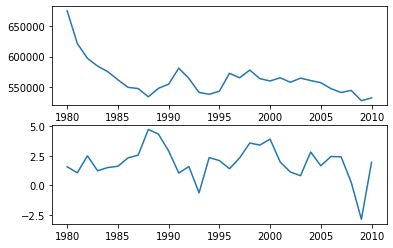

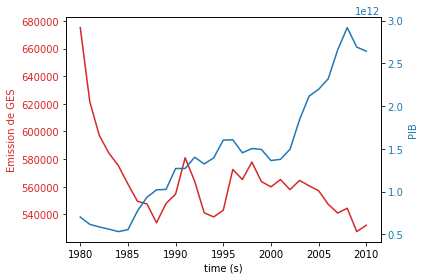

In [28]:
#Sur deux subplots différents
plt.subplot(211)
plt.plot(t[0:31],df1.loc['FRA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T)
plt.subplot(212)
plt.plot(t[0:31],df1.loc['FRA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T)

plt.show()

#Sur le même plot\n",

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['FRA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('PIB', color=color)  
ax2.plot(t[0:31], df1.loc['FRA_GDP (current US$)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

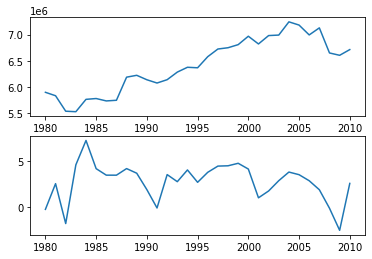

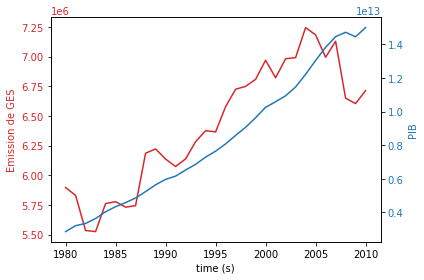

In [29]:
#Sur deux subplots différents
plt.subplot(211)
plt.plot(t[0:31],df1.loc['USA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T)
plt.subplot(212)
plt.plot(t[0:31],df1.loc['USA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T)

plt.show()

#Sur le même plot\n",

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['USA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('PIB', color=color)  
ax2.plot(t[0:31], df1.loc['USA_GDP (current US$)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


On va créer un nouvel indicateur qui va nous donner la croissance à l'année des gazs à effet de serre pour chaque pays :

In [30]:
for i in recherche_ligne('','Émissions totales de GES \(kt d’équivalent CO2\)',df1) :
    df1.loc[i[0:3]+'_croissance émissions GES (kt d’équivalent CO2)'] = df1.loc[i[:-1]][3:44].astype(np.float64).diff()
    print(df1.loc[i[0:3]+'_croissance émissions GES (kt d’équivalent CO2)'])

Country Name          NaN
Country Code          NaN
Indicator Name        NaN
1980                  NaN
1981             -6107.07
1982              3349.01
1983             -391.742
1984             -8973.76
1985               835.89
1986             -731.777
1987              10738.8
1988             -10984.5
1989              3606.22
1990              11463.6
1991             -7045.46
1992              21236.8
1993             -25222.7
1994              4882.14
1995              3573.06
1996             -1094.08
1997               -14045
1998               2183.9
1999                844.3
2000             -1338.74
2001              -408.84
2002              118.528
2003              1367.65
2004              1002.22
2005             -1004.49
2006              520.084
2007              314.712
2008               705.76
2009              913.171
2010              1719.93
2011               849.26
2012              778.513
2013                  NaN
2014                  NaN
2015        

Name: CAF_croissance émissions GES (kt d’équivalent CO2), dtype: object
Country Name          NaN
Country Code          NaN
Indicator Name        NaN
1980                  NaN
1981             -12520.6
1982              -122985
1983             -3245.04
1984             -3812.83
1985              7365.94
1986             -10870.9
1987               5238.1
1988              52069.3
1989               170878
1990              -185370
1991              17464.4
1992             -7475.82
1993                36920
1994               151629
1995              28802.8
1996              -137262
1997             -8694.63
1998               439018
1999              -307493
2000             -60951.3
2001             -42108.5
2002               190152
2003              42686.9
2004              88763.7
2005              -190338
2006              45123.8
2007              -2855.7
2008              16859.2
2009              -159062
2010                14274
2011               269344
2012             -

Name: ECA_croissance émissions GES (kt d’équivalent CO2), dtype: object
Country Name              NaN
Country Code              NaN
Indicator Name            NaN
1980                      NaN
1981                  -190335
1982                   -95012
1983                  16182.2
1984                  67960.2
1985                   117967
1986                   169998
1987                  88591.2
1988                   153055
1989                  16065.9
1990                   399989
1991                  -404573
1992                  -685649
1993                  -350410
1994                  -517058
1995                 -70867.5
1996                   136874
1997                  -427189
1998                   799034
1999             -1.09443e+06
2000                   355857
2001                  -120515
2002                   407352
2003                   681803
2004             -1.10708e+06
2005                  84356.5
2006                   301168
2007                  -15376

Name: HKG_croissance émissions GES (kt d’équivalent CO2), dtype: object
Country Name          NaN
Country Code          NaN
Indicator Name        NaN
1980                  NaN
1981             -866.656
1982              2630.04
1983             -836.221
1984              969.878
1985             -153.793
1986              603.224
1987              664.567
1988              512.851
1989             -673.451
1990             -107.775
1991              1716.22
1992             -1051.69
1993              986.627
1994              258.373
1995              1191.12
1996               364.23
1997             -1068.22
1998              6719.43
1999             -8840.63
2000              7932.06
2001             -9392.71
2002              2331.67
2003              7923.88
2004             -7786.22
2005              8200.66
2006             -6520.26
2007              2491.88
2008              607.323
2009              91.6988
2010              -213.84
2011              420.421
2012              

Country Name              NaN
Country Code              NaN
Indicator Name            NaN
1980                      NaN
1981                  -111407
1982                   120453
1983                 -18238.9
1984                  -255004
1985                  81434.5
1986                   125262
1987                   305002
1988                  -181561
1989                  51939.2
1990                   207687
1991                 -44825.6
1992                   108585
1993                   193106
1994                  -408383
1995                   183394
1996                   113248
1997                  81750.2
1998                   845966
1999                  -770205
2000                  -492468
2001                 -29109.5
2002                   323238
2003                   252688
2004                   413891
2005                   577943
2006                  -935266
2007              1.31774e+06
2008             -1.35774e+06
2009                  -377230
2010      

Country Name          NaN
Country Code          NaN
Indicator Name        NaN
1980                  NaN
1981              -331590
1982              -500744
1983               -86321
1984               356173
1985               132504
1986             -13612.5
1987                31879
1988               663305
1989               310585
1990              -330953
1991             -1854.86
1992             -76462.2
1993               128646
1994               376031
1995               136404
1996               264866
1997               527841
1998               372568
1999              -152971
2000               129875
2001             -81593.4
2002               275004
2003               153298
2004               469364
2005              -443820
2006              88518.2
2007               139352
2008              -786013
2009              -345379
2010              188.944
2011              84907.7
2012              -141097
2013                  NaN
2014                  NaN
2015        

Name: SVK_croissance émissions GES (kt d’équivalent CO2), dtype: object
Country Name          NaN
Country Code          NaN
Indicator Name        NaN
1980                  NaN
1981               173.96
1982             -584.589
1983              1716.18
1984              1159.69
1985              -595.02
1986             -73.1323
1987              403.199
1988              2748.96
1989              -734.94
1990             -654.617
1991             -1447.84
1992             -705.003
1993              481.912
1994               24.599
1995              538.007
1996              1218.51
1997              1710.26
1998             -342.198
1999             -323.996
2000             -205.176
2001              767.328
2002              647.844
2003             -405.764
2004              127.988
2005              302.402
2006              414.766
2007              150.888
2008              319.723
2009              -1799.1
2010              440.503
2011             -380.184
2012             -

Name: VCT_croissance émissions GES (kt d’équivalent CO2), dtype: object
Country Name          NaN
Country Code          NaN
Indicator Name        NaN
1980                  NaN
1981             -2719.32
1982               3794.9
1983              140.271
1984                -5304
1985              3396.72
1986              5319.27
1987              10647.6
1988             -5763.03
1989              7548.84
1990                12932
1991             -2073.16
1992              5116.59
1993              11515.3
1994             -12812.1
1995              15811.9
1996              12275.1
1997              10054.4
1998              35677.2
1999             -54784.9
2000                20697
2001              13992.6
2002             -32784.2
2003              48380.9
2004             -22704.2
2005              -3307.3
2006              750.943
2007              24235.2
2008             -8946.41
2009              -5407.3
2010              2956.09
2011              6937.57
2012              

Maintenant qu'on à la croissance des émissions de gazs à effet de serre par an, on peut représenter la croissance du PIB et celle-ci sur le même graphe :

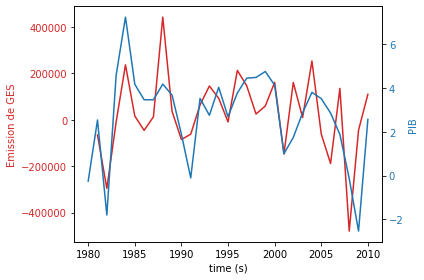

In [35]:
#Sur le même plot,

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['USA_croissance émissions GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('Croissance du PIB', color=color)  
ax2.plot(t[0:31], df1.loc['USA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

On peut voir qu'il y a apparemment une certaine concommitance des courbes, cela-dit il faut faire attention aux effets d'échelles car ici le PIB ne passe presque jamais dans le négatif (ce qui est loin d'être le cas de la croissance des émissions de gaz à effet de serre). On va essayer de le faire dans le cas de la France pour se faire plus d'idées :

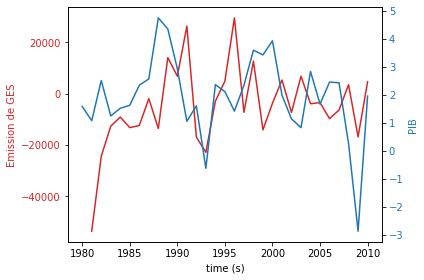

In [36]:
#Sur le même plot,

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['FRA_croissance émissions GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('Croissance du PIB', color=color)  
ax2.plot(t[0:31], df1.loc['FRA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Idée : on pourrait essayer de faire du clustering afin de déterminer la dépendance de la croissance à certains facteurs afin d'essayer de prédire la dépendance de la croissance à l'émission de gaz à effet de serre.

Je vais essayer de régresser la croissance du PIB

# ANNEXE : Comment on a galéré à ouvrir ces putains de fichier de merde

In [27]:
emission_GES = pd.read_csv("chiffre_GES_total.csv", skiprows = [0,1])
emission_GES.head(2)

,Afghanistan,AFG,Émissions totales de GES (kt d’équivalent CO2),EN.ATM.GHGT.KT.CE,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,18168.86,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65
0,Angola,AGO,Émissions totales de GES (kt d’équivalent CO2),EN.ATM.GHGT.KT.CE,NaN,NaN,NaN,NaN,NaN,NaN,...,41657.164846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albanie,ALB,Émissions totales de GES (kt d’équivalent CO2),EN.ATM.GHGT.KT.CE,NaN,NaN,NaN,NaN,NaN,NaN,...,8898.640911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#print(emmisssion_GES["Country Name"])    #ça retourne une erreur : ce n'est pas un nom de variable
#print(emission_GES['Last Updated Date'])   #c'est bien une variable
print(emission_GES.index)

RangeIndex(start=0, stop=262, step=1)


On a bien un système de multiindex ici, qui semble être mal fait puisque les seules variables restantes dans ce df sont les trois dernières colonnes (last updated, date et unnamed), ce qui n'est pas intéressant. En fait il n'arrive pas à lire corrrectement le fichier csv, d'où le problème. 
Il faut donc trouver comment supprimer ce problème, i.e. faire en sorte que le read_csv ne détecte pas la ligne 'Last Updated Date,"2020-10-15",' comme la liste des variables de notre df. Le plus simple serait de supprimer cette ligne via le document ecxel, mais lorsque l'on sauvegarde ces modifications on altère le document (problème d'encodage et de mise en page), ce qui rend cettte solution impraticable.
On va donc tenter d'ouvrir le document modififié (où l'on a enlevé la ligne qui pose problème) avec un pd.open_excel

In [ ]:
GES = pd.read_excel('chiffre_GES_total.xlsx')
GES.head(3)

Ca ne marche pas non plus : il considèe que le doc xlsx n'a qu'une (très longue) colomne. Il interprète donc l'ensemble de la base de données comme un index, ce qui est assez inutile...
Comme on est intelligent , on modifie avec le bloc notes pour enlever les premières lignes, et ça MARCHE

In [ ]:
emission_GES = pd.read_csv("chiffre_GES_total1.csv")
emission_GES.head(10)